In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
from datetime import date
    
df = pd.read_csv('../../data/imp_exp_prod_flat_all.csv')
df.drop(columns='Row Number', inplace=True)
df = df[['Area', 'Item', 'Year', 'Production', 'Import Quantity', 'Export Quantity']]
df.rename(columns={'Area': 'Country', 'Item':'Produce', 'Production':'Production Quantity'}, inplace=True)
df.head()

,Country,Produce,Year,Production Quantity,Import Quantity,Export Quantity
0,Armenia,Potatoes,2000,290260.0,390.0,300.0
1,Armenia,Potatoes,2001,363834.0,2290.0,0.0
2,Armenia,Potatoes,2002,374263.0,1918.0,0.0
3,Armenia,Potatoes,2003,507518.0,2853.0,7.0
4,Armenia,Potatoes,2004,576427.0,1553.0,0.0


In [2]:
# create a lookup table for countries and their centroid locations
lookup = pd.read_csv('../../data/country_centroids.csv')
lookup.rename(columns={'country':'code'}, inplace=True)
lookup.index = lookup['name']
(lookup.drop(columns=['name'])).to_csv('../../data/countries_lookup.csv')


# FIXME --------------------------------------------------------------------------
# ********************************************************************************
# Assuming that China is a sum of mainland, taiwan, hong kong and macao
# 'Serbia and Montenegro' - set coordinates to average of Serbia and Montenegro
# 'South Sudan' and 'Sudan (former)'- set coordinates to Sudan's coordinates

# print regions that are not present in the countries lookup table
set(df[~df['Country'].isin(lookup['name'])]['Country'])

{'Africa',
 'Americas',
 'Asia',
 'Australia & New Zealand',
 'Caribbean',
 'Central America',
 'Central Asia',
 'China',
 'Eastern Africa',
 'Eastern Asia',
 'Eastern Europe',
 'Europe',
 'European Union',
 'Land Locked Developing Countries',
 'Least Developed Countries',
 'Low Income Food Deficit Countries',
 'Melanesia',
 'Middle Africa',
 'Net Food Importing Developing Countries',
 'Northern Africa',
 'Northern America',
 'Northern Europe',
 'Occupied Palestinian Territory',
 'Oceania',
 'Polynesia',
 'Small Island Developing States',
 'South America',
 'South-Eastern Asia',
 'Southern Africa',
 'Southern Asia',
 'Southern Europe',
 'Western Africa',
 'Western Asia',
 'Western Europe',
 'World'}

In [3]:
# remove the regions printed above from the dataframe
df = df[df['Country'].isin(lookup.index)]

# randomly print 10 entries from the dataframe for an example of what it contains
df.sample(n=10)

,Country,Produce,Year,Production Quantity,Import Quantity,Export Quantity
143969,Egypt,"Peas, dry",2008,20.0,8324.0,846.0
90991,Cyprus,Grapes,2011,25064.0,2068.0,266.0
52780,Spain,Artichokes,2015,204111.0,109.0,14489.0
33784,Norway,"Peas, green",2012,2685.0,1415.0,9.0
4587,Iraq,Cucumbers and gherkins,2004,433000.0,31514.0,7.0
18817,Lithuania,Cabbages and other brassicas,2005,144511.0,7554.0,2659.0
25891,Morocco,Apples,2015,674153.0,8698.0,1077.0
154640,Argentina,"Peas, dry",2012,53315.0,227.0,128998.0
152627,Greece,Garlic,2014,9420.0,1089.0,489.0
53349,Spain,Currants,2006,200.0,97.0,275.0


In [4]:
def getMaximumQuantity(selectedData):
    largestProduced = int(selectedData.nlargest(1, 'Production Quantity')['Production Quantity'])
    largestImported = int(selectedData.nlargest(1, 'Import Quantity')['Import Quantity'])
    largestExported = int(selectedData.nlargest(1, 'Export Quantity')['Export Quantity'])
    return max([largestProduced, largestImported, largestExported])

timeObject = {}
timeObject['countries'] = sorted(set(df['Country']))

for country in timeObject['countries']:
    countryObject = {}
    
    countryObject['produce'] = sorted(set((df[df['Country'] == country])['Produce']))
    for produce in countryObject['produce'] :
        produceObject = {}
        selected = df[(df['Country'] == country) & (df['Produce'] == produce)]
        
        # save the available years and production, import and export quantities for each produce in each year
        produceObject['available_years'] = sorted(set(selected['Year']))
        produceObject['largest_quantity'] = getMaximumQuantity(selected)
        produceObject['Production'] = []
        produceObject['Imports'] = []
        produceObject['Exports'] = []
        
        for year in produceObject['available_years']:
            currentYearData = (selected[selected['Year'] == year])
            (produceObject['Production']).append({'year': date(year, 1, 1).year, 'quantity': int(currentYearData['Production Quantity'])})
            (produceObject['Imports']).append({'year': date(year, 1, 1).year, 'quantity': int(currentYearData['Import Quantity'])})
            (produceObject['Exports']).append({'year': date(year, 1, 1).year, 'quantity': int(currentYearData['Export Quantity'])})
            
        countryObject[produce] = produceObject
    
    timeObject[country] = countryObject 

In [5]:
json.dump(timeObject, open('../../data/time_analysis.json', 'w'))

['#f77189', '#50b131', '#3ba3ec']

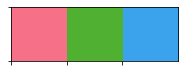

In [6]:
# generate colors for the line chart
barChartPalette = sns.color_palette('husl', 3)
sns.palplot(barChartPalette)
barChartPalette.as_hex()